In [1]:
!source $CONDA_PREFIX/etc/conda/activate.d/env_vars.sh

import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

2023-08-19 18:59:47.586666: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-19 18:59:48.327799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
rvl_cdip_images_dir = "/scratch/gpfs/RUSTOW/rvl_cdip_images/labels"

In [3]:
rvl_cdip_images_train_file_path = os.path.join(rvl_cdip_images_dir, "train.txt")
rvl_cdip_images_test_file_path = os.path.join(rvl_cdip_images_dir, "test.txt")
rvl_cdip_images_val_file_path = os.path.join(rvl_cdip_images_dir, "val.txt")

In [4]:
with open(rvl_cdip_images_train_file_path, "r") as f:
    rvl_cdip_images_train_file_list = f.readlines()
    
with open(rvl_cdip_images_test_file_path, "r") as f:
    rvl_cdip_images_test_file_list = f.readlines()
    
with open(rvl_cdip_images_val_file_path, "r") as f:
    rvl_cdip_images_val_file_list = f.readlines()

In [5]:
root_dir = "/scratch/gpfs/RUSTOW/rvl_cdip_images/images"

In [6]:
rvl_cdip_images_train_file_list = [x.split(" ")[0].strip() for x in rvl_cdip_images_train_file_list]
rvl_cdip_images_test_file_list = [x.split(" ")[0].strip() for x in rvl_cdip_images_test_file_list]
rvl_cdip_images_val_file_list = [x.split(" ")[0].strip() for x in rvl_cdip_images_val_file_list]

In [7]:
rvl_cdip_images_train_file_list = [os.path.join(root_dir, x) for x in rvl_cdip_images_train_file_list]
rvl_cdip_images_test_file_list = [os.path.join(root_dir, x) for x in rvl_cdip_images_test_file_list]
rvl_cdip_images_val_file_list = [os.path.join(root_dir, x) for x in rvl_cdip_images_val_file_list]

In [8]:
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def rotatedRectWithMaxArea(w, h, angle):
    if w <= 0 or h <= 0:
        return 0, 0

    width_is_longer = w >= h
    side_long, side_short = (w, h) if width_is_longer else (h, w)

    sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))
    if side_short <= 2.*sin_a*cos_a*side_long or abs(sin_a-cos_a) < 1e-10:
        x = 0.5*side_short
        wr, hr = (x/sin_a, x/cos_a) if width_is_longer else (x/cos_a, x/sin_a)
    else:
        cos_2a = cos_a*cos_a - sin_a*sin_a
        wr, hr = (w*cos_a - h*sin_a)/cos_2a, (h*cos_a - w*sin_a)/cos_2a

    return wr, hr

def random_rotation(image):
    def rotate_fn(image_np):
        image_np = np.array(image_np)

        h, w, _ = image_np.shape
        center = (w / 2, h / 2)
        min_angle_rad, max_angle_rad = -math.pi/8, math.pi/8
        angle_rad = np.random.uniform(min_angle_rad, max_angle_rad)
        angle_deg = math.degrees(angle_rad)
        
        M = cv2.getRotationMatrix2D(center, angle_deg, 1.0)
        rotated_image_np = cv2.warpAffine(image_np, M, (w, h))

        wr, hr = rotatedRectWithMaxArea(w, h, angle_rad)
        
        # Get the starting and ending coordinates for the crop
        x1 = int(center[0] - wr // 2)
        x2 = int(center[0] + wr // 2)
        y1 = int(center[1] - hr // 2)
        y2 = int(center[1] + hr // 2)
        
        cropped_image_np = rotated_image_np[y1:y2, x1:x2]

        return cropped_image_np, np.array(angle_deg, dtype=np.float32)

    cropped_image, angle = tf.py_function(rotate_fn, [image], [tf.float32, tf.float32])
    cropped_image.set_shape([None, None, 3])
    return cropped_image, angle

def preprocess(image):
    rotated_image, angle = random_rotation(image)
    rotated_image = tf.image.resize(rotated_image, [224, 224])
    rotated_image = rotated_image / 255.0

    return rotated_image, angle


In [9]:
batch_size = 128

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(rvl_cdip_images_train_file_list)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

2023-08-19 18:59:50.095617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79268 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [11]:
test_dataset = tf.data.Dataset.from_tensor_slices(rvl_cdip_images_test_file_list)
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(random_rotation, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
val_dataset = tf.data.Dataset.from_tensor_slices(rvl_cdip_images_val_file_list)
val_dataset = val_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(random_rotation, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size) 
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

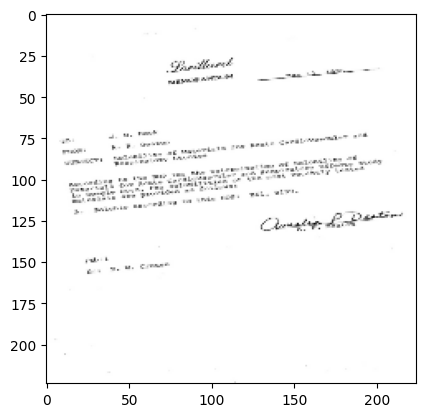

In [13]:
# show some of the images
for image, y in train_dataset.take(1):
    plt.imshow(image[0])
    plt.show()

In [14]:
base_model = tf.keras.applications.MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalMaxPool2D(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="linear")
])

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae"])

In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


2023-08-19 19:00:02.218374: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-19 19:00:02.304550: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-19 19:00:03.159602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-19 19:00:03.282499: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x14f62f3cfde0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-19 19:00:03.282537: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-08-19 19:00:03.287109: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-19 19:00:03.385882:

 102/2500 [>.............................] - ETA: 48:36 - loss: 67.7843 - mae: 4.7198